# Fifth notebook on dermoscopic images analysis

## New
In this notebook I'll focus on determining over/under exposures, and color/hue shift.<br>
We are 'normalizing' images - all images cropped to square, and resized to 1024 * 1024px

## Carried over from the previous notebook
One of the most popular approaches to defining sharpness/bluriness of an images is to apply Laplacian operator which is an approximation of second derivative over discrete 2D matrix. As the result we have near 0 values around edges in the original image, therefore variance of the result can give us an estimate of how well the edges are defined in the image.

This approach works quite well in the regular images analysis and is widely used in computer vision application. However to compute the lapalcian we have to convert an RGB image into gray-scale space, loosing color information. Moreover human skin is quite smooth and lack many pronounced details, leading to significantly fewer well defined edges in any dermoscopic image.

That's why I showed in the first notebook that we can't use this simple approach of analyzing variance of laplacian operator over gray version of the dermoscopic images of the leisons. In the absolute majority of the images the variance is too low to set a definitive threshold on which to base the decision.

Therefore lets analyze these images in different color spaces and estimate **'sharpness index'** per each channel (still using variance of the laplacian operator). 
**The higher the number of the index the better** since it is a reflection of how many edges are there in the image.
We'll analyze the images by separate channels, plot the histograms, and display basic descriptive analytics.

In [19]:
!pip install simplejpeg 

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from skimage.exposure import is_low_contrast, rescale_intensity
import random
import simplejpeg 
from tqdm import tqdm

# Directory
directory = '../input/siim-isic-melanoma-classification'
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"
img_dir = IMAGE_PATH+'/jpeg/train'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
print(f'There are {train_df.shape[0]} records in the train set')

random.seed(1970)

There are 33126 records in the train set


Split data into benign and malignant leisons subsets. Pick 9 random samples from each for furthere analysis.

In [21]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']
print(f'There are {benign.shape[0]} records in the benign set, and {malignant.shape[0]} in the malignant dataset')

random9_mal = [np.random.choice(malignant['image_name'].values+'.jpg') for i in range(9)]
random9_ben = [np.random.choice(benign['image_name'].values+'.jpg') for i in range(9)]

There are 32542 records in the benign set, and 584 in the malignant dataset


In [22]:
def crop(img_name, space = 'rgb'):
    with open(img_name, 'rb') as f:
        tf = f.read() # Read whole file in the file_content string
        if simplejpeg.is_jpeg(tf):
            img = simplejpeg.decode_jpeg(tf, colorspace = space) # could be 'bgr' or 'rgb'

    h, w, _ = img.shape
    min_d = min(h, w)
    crop_d = ((max(h, w) - min_d) /2)
    x1 = 0; y1 = 0
    x2 = w; y2 = h
    if h > w:
        y1 = int(crop_d); y2 = int(h - crop_d) 
    else:
        x1 = int(crop_d); x2 = int(w - crop_d)
        
    if min_d > 1024:
        interpolation = cv2.INTER_AREA 
    else:
        interpolation = cv2.INTER_CUBIC
        # interpolation = cv2.INTER_LINEAR 
        
    resized = cv2.resize(img[y1:y2, x1:x2], (1024, 1024), interpolation = interpolation)
    return resized


def read_imgBGR(filename):
    img_BGR = cv2.imread(os.path.join(img_dir, filename))
    return img_BGR


def variance_of_laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    res = cv2.Laplacian(image, cv2.CV_64F)
    lap_var = res.var()
    return res, lap_var

# show 9 images with Blur Index in 3*3 grid
def show9(images, l_type):
    print(f'{l_type} images with variance of laplacian of gray version of the images as Sharpness Index')

    # Adjust the size of your images
    plt.figure(figsize=(10,8))

    # Iterate and plot random images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = crop(os.path.join(img_dir, images[i]))
#        img = plt.imread(os.path.join(img_dir, images[i]))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        plt.title(f'Sharpness Index : {fm:.2f}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()
    
def show9_RGB(images, l_type):
    print(f'Display {l_type} Images')
    N_subplots = 6
    color = ('b','g','r')

    # Iterate and plot random images
    for i in range(9):
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(3)
        img = crop(os.path.join(img_dir, images[i]))
#        img = plt.imread(os.path.join(img_dir, images[i]))
        ax = fig.add_subplot(1, N_subplots, 1)
        imgplot = plt.imshow(img)
        ax.set_title(f'Size: {img.shape}')
        plt.axis('off')

        for i,col in enumerate(color):
            ax = fig.add_subplot(1, N_subplots, i+2)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')

        color = ('b','g','r')
        ax = fig.add_subplot(1, N_subplots, 5)
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col)
            plt.xlim([0,256])

        ax = fig.add_subplot(1, N_subplots, 6)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mat, fm = laplacian(gray)
        ax.set_title(f'Bluriness index : {fm:.2f}')
        plt.hist(mat.ravel(), bins=100) 
        plt.show()    
        
# pass an image in BGR format as an input
def BGR2MI(img):
    MI = 100 * np.log10(1/(img[:,:,2].astype('float')+1))
    MI_norm = (MI * 0.0042 + 1) * 255 # as proposed in the original paper by Zhao Liu et al. (2012)
    MI_s = MI + abs(MI.min())
    MI_rescaled = 255 * (MI_s / abs(MI_s.max()))
    return MI.astype('int16'), MI_rescaled.astype('int16'), MI_norm.astype('int16')

# pass an image in BGR format as an input
def BGR2EI(img):
    EI = 100 * (np.log10(1/(img[:,:,1].astype('float')+1)) - 1.44 * np.log10(1/(img[:,:,2].astype('float')+1)))
    EI_norm = (EI * 0.0017 + 0.4098) * 255 # as proposed in the original paper by Zhao Liu et al. (2012)
    EI = EI + abs(EI.min())
    EI_rescaled = 255 * (EI / abs(EI.max()))
    return EI.astype('int16'), EI_rescaled.astype('int16'), EI_norm.astype('int16')                


## Melanin Index and Erythema Index

In the previous notebook I introduced Melanin Index and Erythema Index based on the ideas from <a href='https://rdcu.be/c3IJD'>Zhao Liu et al. (2012)</a> . I believe we can use it as for image quality analysis and so for our future lesion classifier.

In [23]:
def show_image_analytics(images, l_type):
    print(f'{l_type} Images')
    N_rows = 4
    N_cols = 4
    HSV_color = ('H','S','V')
    BGR_color = ('b','g','r')
    YCrCb_color = ('Y','Cr','Cb')
    plot_color = ('r','g','b')
    pcts = [5, 25, 50, 75, 95]
    blur_idxs = {'r': 0, 'g': 0, 'b': 0, 'H': 0, 'S': 0, 'V': 0, 'Y': 0, 'Cr': 0, 'Cb': 0, 'MI': 0, 'EI': 0, 'Gray': 0}


    # Iterate and plot random images
    for n_img in range(len(images)):
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(14)
        img_BGR = crop(os.path.join(img_dir, images[n_img]), 'bgr')
#        img_BGR = cv2.imread(os.path.join(img_dir, images[n_img]))
        ax = fig.add_subplot(N_rows, N_cols, 1)
        imgplot = plt.imshow(cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB))
        ax.set_title(f'Size: {img_BGR.shape}')
        plt.axis('off')

        MI, MI_rescaled, MI_norm = BGR2MI(img_BGR)
        ax = fig.add_subplot(N_rows, N_cols, 2)
        imgplot = plt.imshow(MI_norm, cmap='gist_heat')
#         imgplot = plt.imshow(MI_norm, cmap='gray')
        ax.set_title(f'Melanin Index')
        plt.axis('off')
        
        EI, EI_rescaled, EI_norm = BGR2EI(img_BGR)      
        ax = fig.add_subplot(N_rows, N_cols, 3)
        imgplot = plt.imshow(EI_norm, cmap='gist_heat')
#         imgplot = plt.imshow(EI_norm, cmap='gray')
        ax.set_title(f'Erythema Index')
        plt.axis('off')
        
        blur_idxs['MI'] = variance_of_laplacian(MI_norm)
        blur_idxs['EI'] = variance_of_laplacian(EI_norm)
        
        gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
        ax = fig.add_subplot(N_rows, N_cols, 4)
        mat, blur_idxs['Gray'] = laplacian(gray)
        ax.set_title('Laplacian of gray image')
        plt.hist(mat.ravel(), bins=100) 

        for i,col in enumerate(BGR_color):
            ax = fig.add_subplot(N_rows, N_cols, N_cols + i + 1)
            imgplot = plt.imshow(img_BGR[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')
            blur_idxs[col] = variance_of_laplacian(img_BGR[:,:,i])

        ax = fig.add_subplot(N_rows, N_cols, N_cols * 1 + 4)
        ax.set_title(f'Histograms of {BGR_color}')
        for i,col in enumerate(BGR_color):
            histr = cv2.calcHist([img_BGR],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col, label = BGR_color[i])
            plt.xlim([0,256])
        ax.legend()

        img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
        HSV_pcts = np.percentile(img[:,:,2], pcts)
        for i,col in enumerate(HSV_color):
            ax = fig.add_subplot(N_rows, N_cols, N_cols * 2 + i + 1)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')
            blur_idxs[col] = variance_of_laplacian(img[:,:,i])

        ax = fig.add_subplot(N_rows, N_cols, N_cols * 2 + 4)
        ax.set_title(f'Histograms of {HSV_color}')
        for i,col in enumerate(['pink','gold','indigo']):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col, label = HSV_color[i])
            plt.xlim([0,256])
        ax.legend()

        img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCR_CB)
        YCrCb_pcts = np.percentile(img[:,:,0], pcts)
        for i,col in enumerate(YCrCb_color):
            ax = fig.add_subplot(N_rows, N_cols, N_cols * 3 + i + 1)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')
            blur_idxs[col] = variance_of_laplacian(img[:,:,i])

        ax = fig.add_subplot(N_rows, N_cols, N_cols * 3 + 4)
        ax.set_title(f'Histograms of {YCrCb_color}')
        for i,col in enumerate(['coral', 'olive', 'maroon']):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col, label = YCrCb_color[i])
            plt.xlim([0,256])
        ax.legend()

        plt.show()

        BGR_pcts = np.percentile(img_BGR, pcts)
        print(f'Percentiles of intensities in RGB space: {dict(zip(pcts,BGR_pcts))}')
        print(f'Percentiles of intensities in HSV space: {dict(zip(pcts,HSV_pcts))}')
        print(f'Percentiles of intensities in YCrCb space: {dict(zip(pcts,YCrCb_pcts))}')
        print('Sharpness Index: ')
        bis = ''
        for k in blur_idxs:
            bis = bis + k + f': {blur_idxs[k]:.2f}  '
        print(bis)
        pcts_contrast = [1, 5, 25, 50, 75, 95, 99]
        gray_pcts = np.percentile(gray, pcts_contrast)
        contrast_clipped = (gray_pcts[-1] - gray_pcts[0])/255
        contrast = (gray.max() - gray.min())/255
        print(f'Full contrast: {contrast:.2f}; clipped (1%-99%) contrast: {contrast_clipped:.2f}') #remove outliers
        
        print('-'*80)

Benign Images


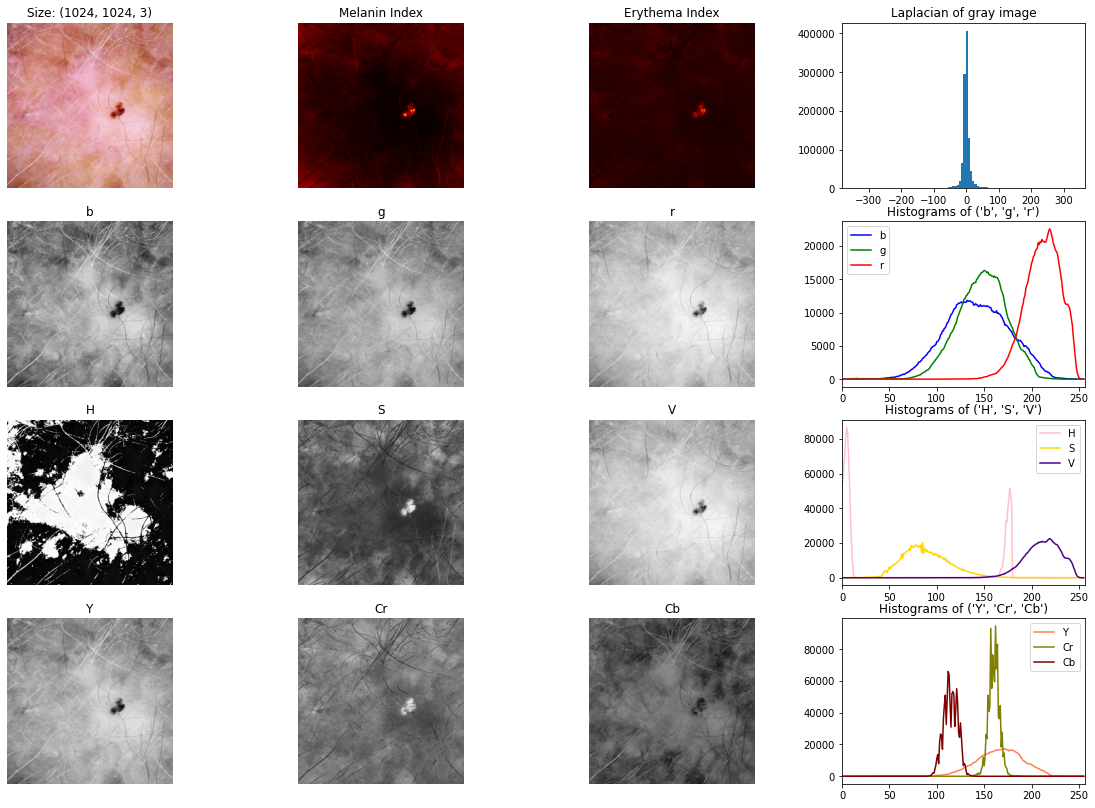

Percentiles of intensities in RGB space: {5: 101.0, 25: 136.0, 50: 166.0, 75: 202.0, 95: 231.0}
Percentiles of intensities in HSV space: {5: 180.0, 25: 200.0, 50: 213.0, 75: 225.0, 95: 240.0}
Percentiles of intensities in YCrCb space: {5: 126.0, 25: 150.0, 50: 167.0, 75: 183.0, 95: 205.0}
Sharpness Index: 
r: 230.17  g: 323.60  b: 370.61  H: 9717.75  S: 162.29  V: 230.28  Y: 287.89  Cr: 14.66  Cb: 11.58  MI: 12.51  EI: 2.25  Gray: 287.89  
Full contrast: 0.87; clipped (1%-99%) contrast: 0.42
--------------------------------------------------------------------------------


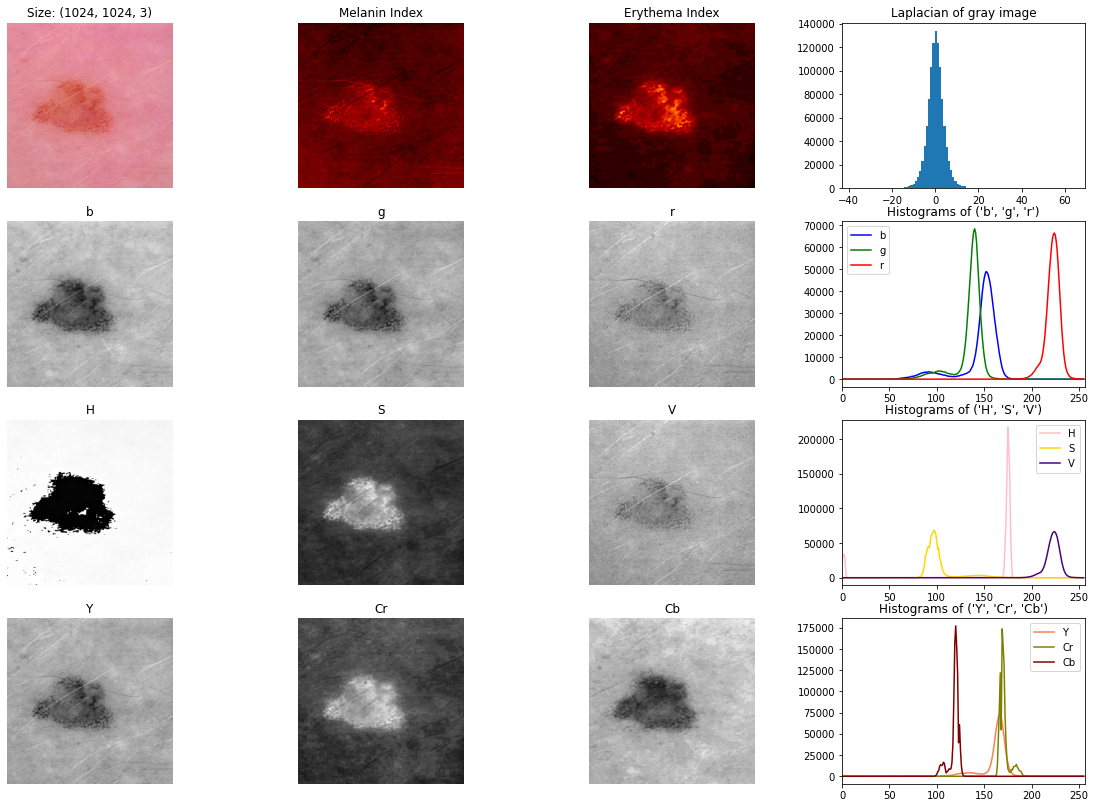

Percentiles of intensities in RGB space: {5: 104.0, 25: 140.0, 50: 152.0, 75: 219.0, 95: 229.0}
Percentiles of intensities in HSV space: {5: 209.0, 25: 219.0, 50: 223.0, 75: 227.0, 95: 233.0}
Percentiles of intensities in YCrCb space: {5: 131.0, 25: 161.0, 50: 165.0, 75: 169.0, 95: 175.0}
Sharpness Index: 
r: 14.71  g: 14.37  b: 15.04  H: 918.02  S: 6.80  V: 14.71  Y: 14.17  Cr: 0.99  Cb: 1.05  MI: 1.95  EI: 0.45  Gray: 14.17  
Full contrast: 0.47; clipped (1%-99%) contrast: 0.24
--------------------------------------------------------------------------------


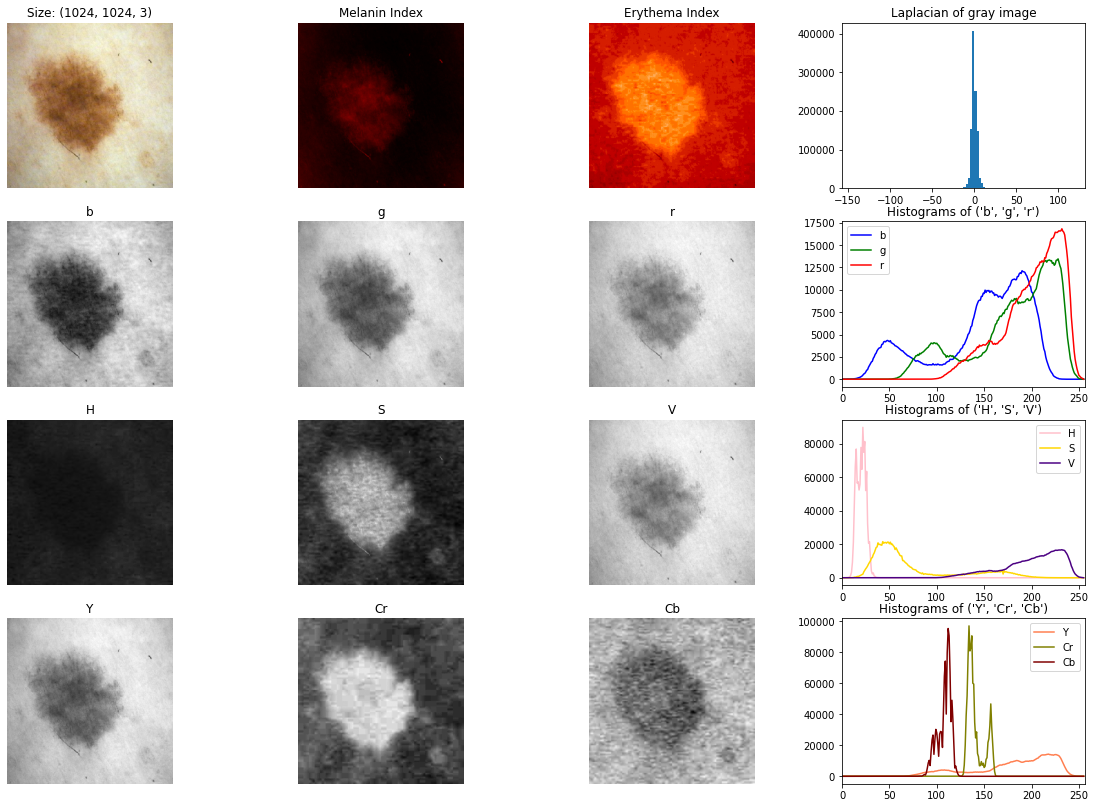

Percentiles of intensities in RGB space: {5: 71.0, 25: 153.0, 50: 187.0, 75: 213.0, 95: 235.0}
Percentiles of intensities in HSV space: {5: 138.0, 25: 183.0, 50: 208.0, 75: 226.0, 95: 239.0}
Percentiles of intensities in YCrCb space: {5: 98.0, 25: 163.0, 50: 193.0, 75: 216.0, 95: 232.0}
Sharpness Index: 
r: 12.27  g: 12.23  b: 12.72  H: 3.19  S: 12.33  V: 12.27  Y: 12.33  Cr: 1.70  Cb: 2.44  MI: 2.35  EI: 0.65  Gray: 12.33  
Full contrast: 0.96; clipped (1%-99%) contrast: 0.62
--------------------------------------------------------------------------------


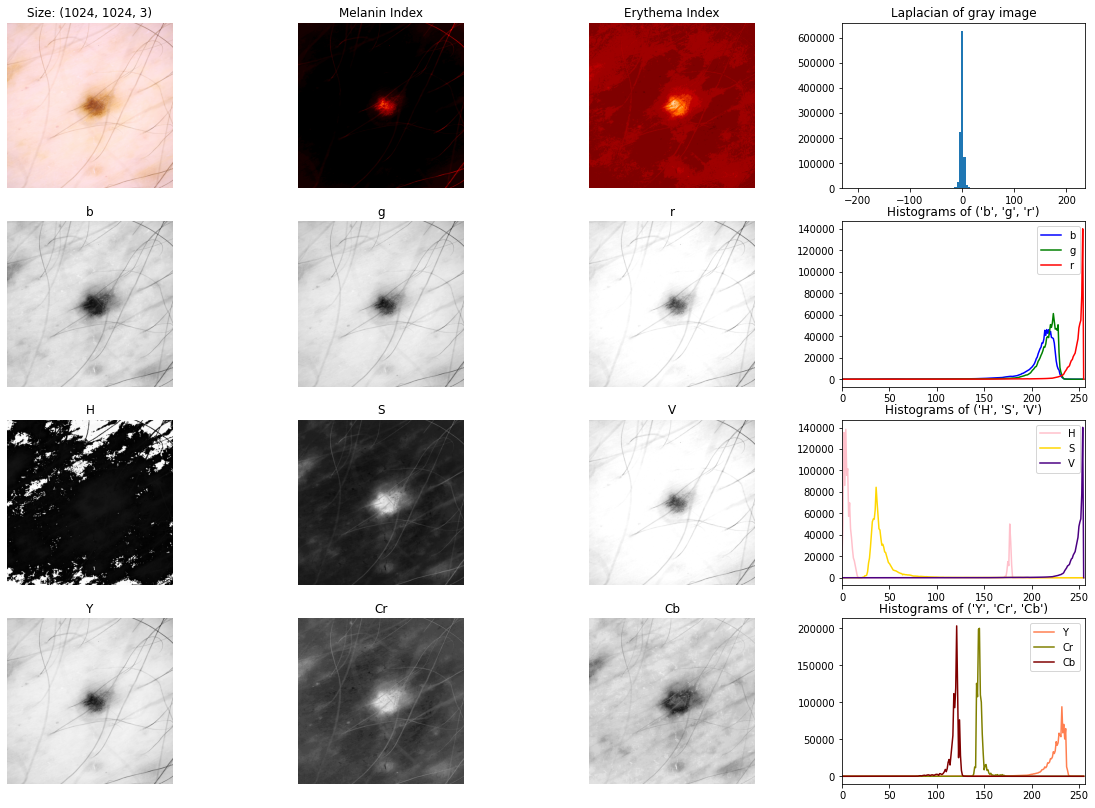

Percentiles of intensities in RGB space: {5: 188.0, 25: 213.0, 50: 222.0, 75: 247.0, 95: 255.0}
Percentiles of intensities in HSV space: {5: 234.0, 25: 247.0, 50: 253.0, 75: 255.0, 95: 255.0}
Percentiles of intensities in YCrCb space: {5: 202.0, 25: 222.0, 50: 229.0, 75: 233.0, 95: 236.0}
Sharpness Index: 
r: 37.60  g: 46.81  b: 55.94  H: 4440.36  S: 24.00  V: 37.60  Y: 43.30  Cr: 2.75  Cb: 3.14  MI: 2.10  EI: 0.70  Gray: 43.30  
Full contrast: 0.65; clipped (1%-99%) contrast: 0.36
--------------------------------------------------------------------------------


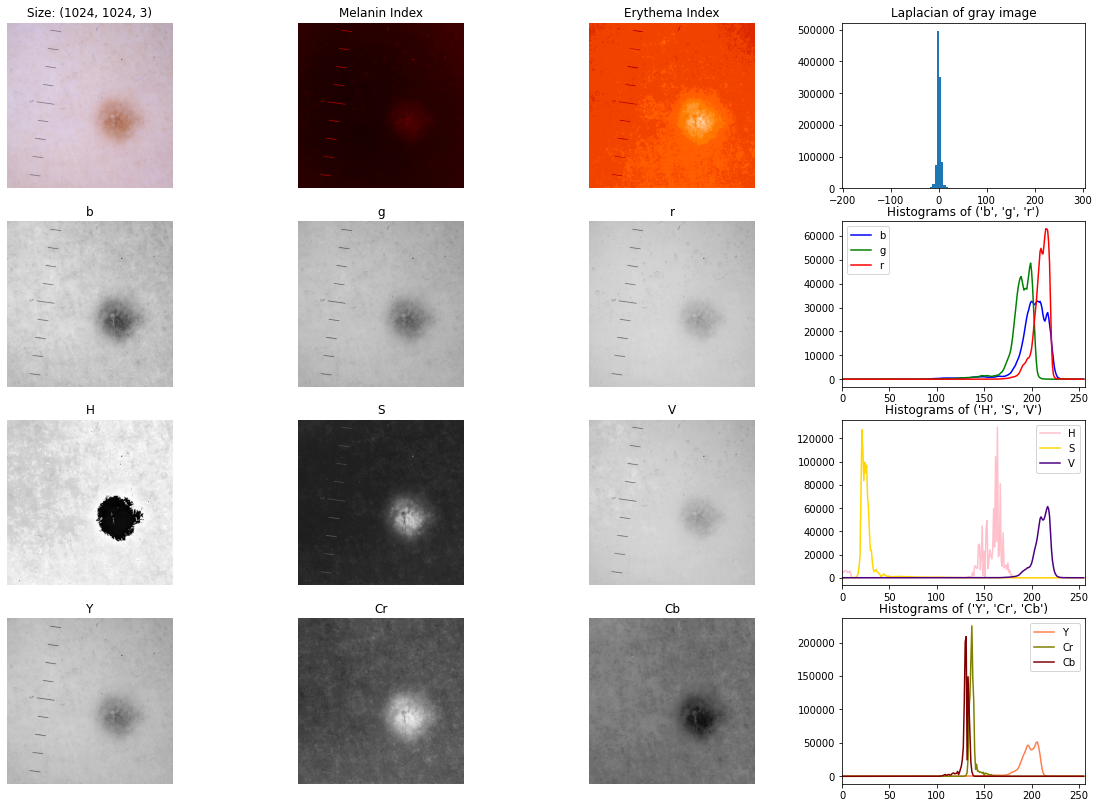

Percentiles of intensities in RGB space: {5: 175.0, 25: 192.0, 50: 202.0, 75: 212.0, 95: 219.0}
Percentiles of intensities in HSV space: {5: 194.0, 25: 206.0, 50: 212.0, 75: 217.0, 95: 221.0}
Percentiles of intensities in YCrCb space: {5: 176.0, 25: 192.0, 50: 198.0, 75: 205.0, 95: 209.0}
Sharpness Index: 
r: 58.72  g: 60.43  b: 64.16  H: 570.20  S: 16.27  V: 60.10  Y: 59.30  Cr: 1.87  Cb: 2.04  MI: 6.83  EI: 0.71  Gray: 59.30  
Full contrast: 0.83; clipped (1%-99%) contrast: 0.26
--------------------------------------------------------------------------------


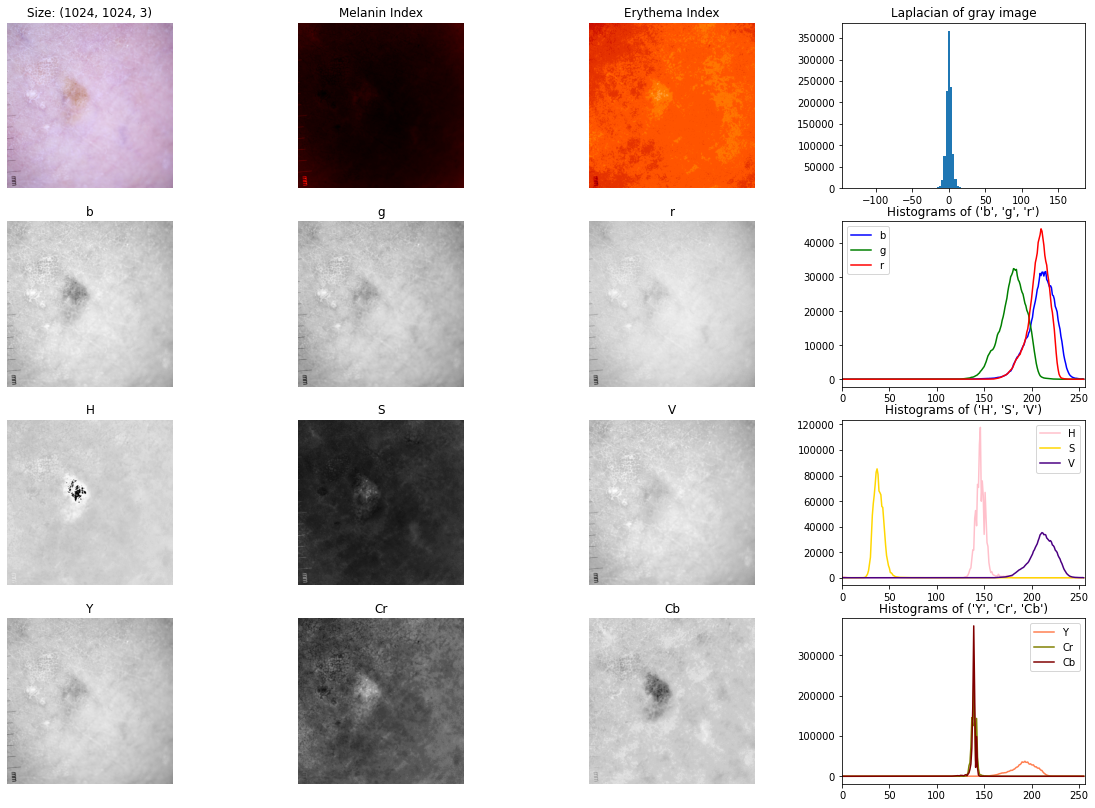

Percentiles of intensities in RGB space: {5: 165.0, 25: 186.0, 50: 202.0, 75: 214.0, 95: 226.0}
Percentiles of intensities in HSV space: {5: 188.0, 25: 204.0, 50: 213.0, 75: 221.0, 95: 231.0}
Percentiles of intensities in YCrCb space: {5: 168.0, 25: 184.0, 50: 193.0, 75: 201.0, 95: 211.0}
Sharpness Index: 
r: 26.35  g: 28.32  b: 31.84  H: 229.57  S: 15.92  V: 28.47  Y: 26.47  Cr: 2.95  Cb: 2.18  MI: 3.39  EI: 0.76  Gray: 26.47  
Full contrast: 0.85; clipped (1%-99%) contrast: 0.23
--------------------------------------------------------------------------------


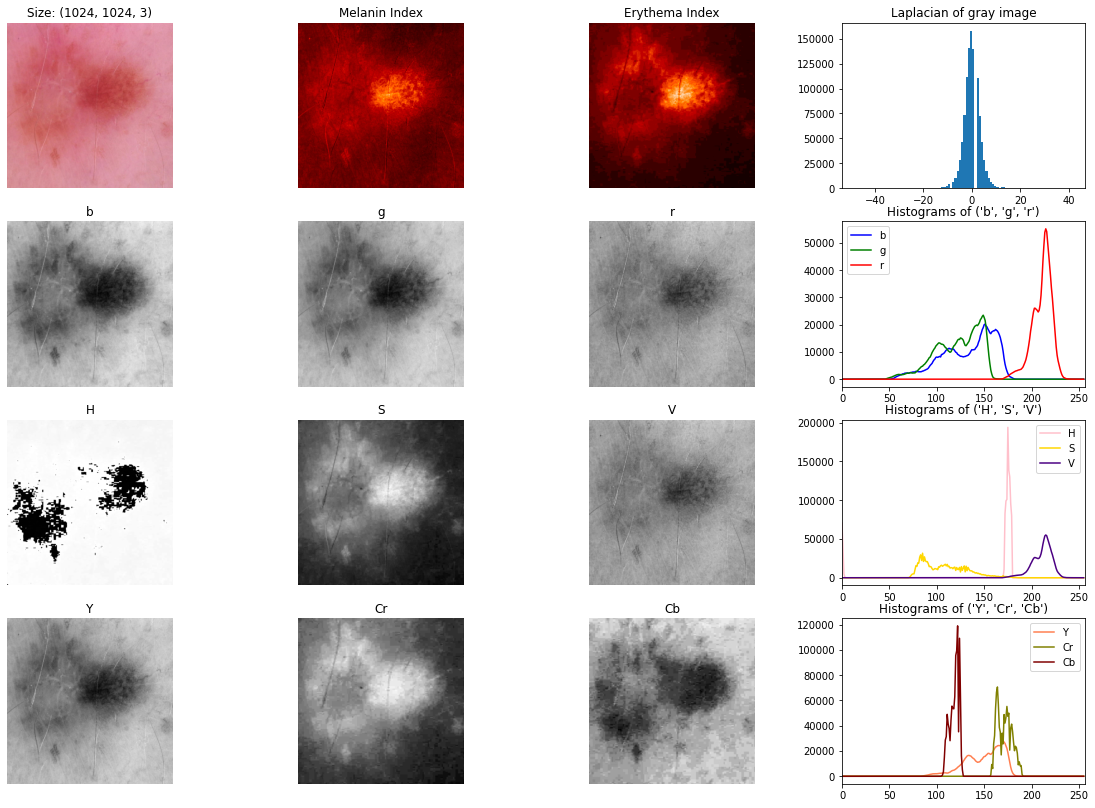

Percentiles of intensities in RGB space: {5: 87.0, 25: 120.0, 50: 149.0, 75: 205.0, 95: 221.0}
Percentiles of intensities in HSV space: {5: 192.0, 25: 205.0, 50: 213.0, 75: 218.0, 95: 225.0}
Percentiles of intensities in YCrCb space: {5: 113.0, 25: 135.0, 50: 154.0, 75: 167.0, 95: 175.0}
Sharpness Index: 
r: 11.91  g: 11.61  b: 12.19  H: 1835.69  S: 6.51  V: 11.91  Y: 11.44  Cr: 0.76  Cb: 0.88  MI: 1.85  EI: 0.47  Gray: 11.44  
Full contrast: 0.48; clipped (1%-99%) contrast: 0.33
--------------------------------------------------------------------------------


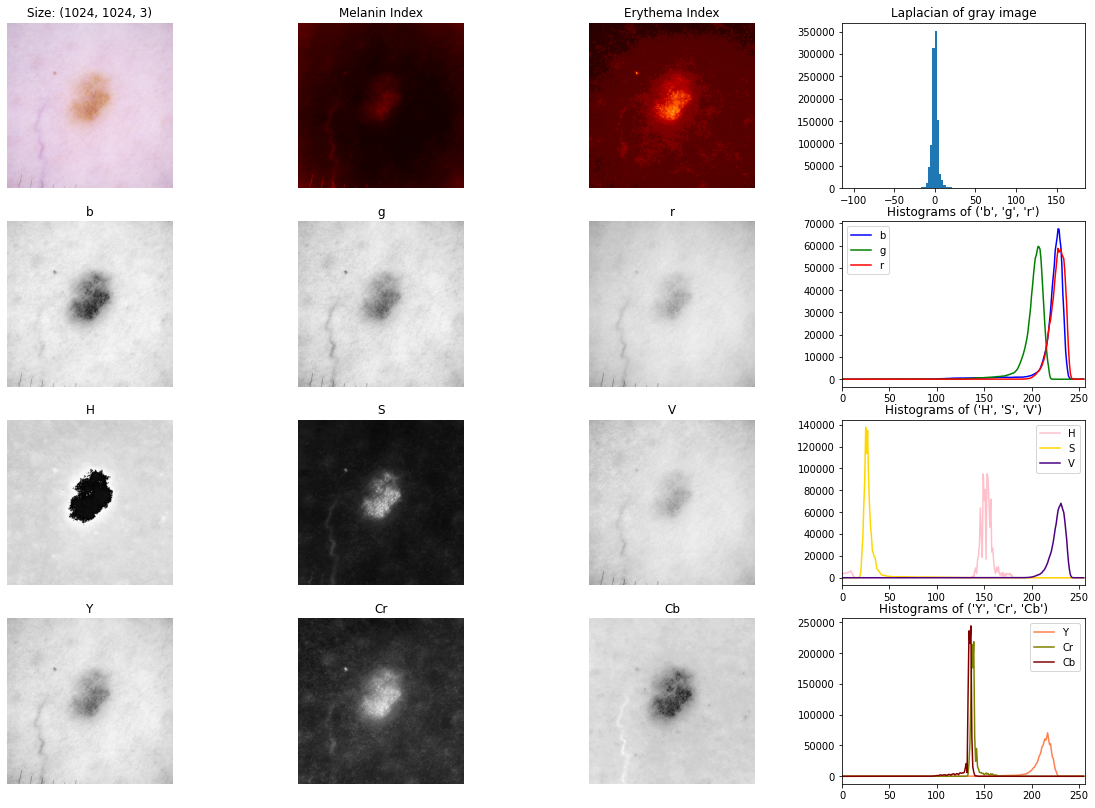

Percentiles of intensities in RGB space: {5: 190.0, 25: 207.0, 50: 222.0, 75: 229.0, 95: 235.0}
Percentiles of intensities in HSV space: {5: 215.0, 25: 224.0, 50: 229.0, 75: 233.0, 95: 237.0}
Percentiles of intensities in YCrCb space: {5: 193.0, 25: 209.0, 50: 214.0, 75: 218.0, 95: 223.0}
Sharpness Index: 
r: 23.78  g: 25.83  b: 26.57  H: 573.69  S: 12.49  V: 23.64  Y: 23.78  Cr: 2.83  Cb: 1.65  MI: 2.25  EI: 0.64  Gray: 23.78  
Full contrast: 0.58; clipped (1%-99%) contrast: 0.24
--------------------------------------------------------------------------------


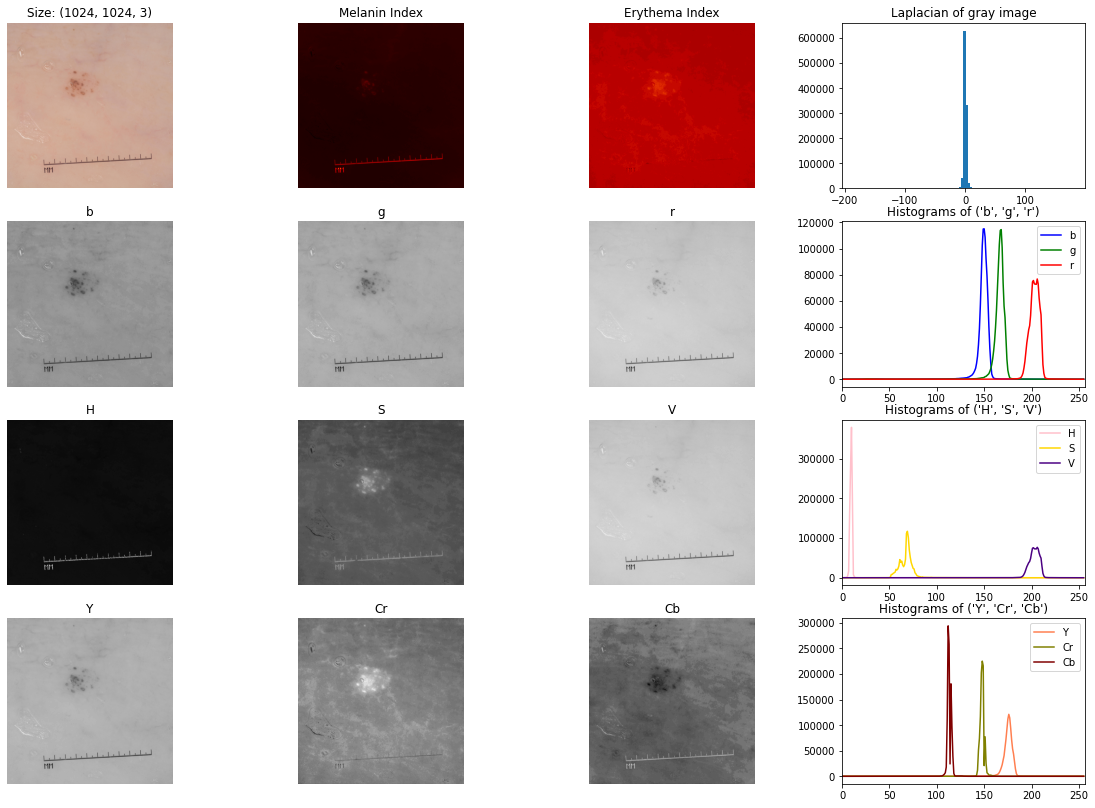

Percentiles of intensities in RGB space: {5: 145.0, 25: 152.0, 50: 167.0, 75: 200.0, 95: 208.0}
Percentiles of intensities in HSV space: {5: 194.0, 25: 200.0, 50: 203.0, 75: 207.0, 95: 210.0}
Percentiles of intensities in YCrCb space: {5: 168.0, 25: 173.0, 50: 176.0, 75: 178.0, 95: 182.0}
Sharpness Index: 
r: 48.15  g: 60.24  b: 42.25  H: 305.35  S: 45.54  V: 48.15  Y: 52.95  Cr: 1.92  Cb: 1.56  MI: 7.69  EI: 0.78  Gray: 52.95  
Full contrast: 0.85; clipped (1%-99%) contrast: 0.14
--------------------------------------------------------------------------------


In [24]:
#show_image_analytics(random9_ben[:2], 'Benign')
show_image_analytics(random9_ben, 'Benign')

Malignant Images


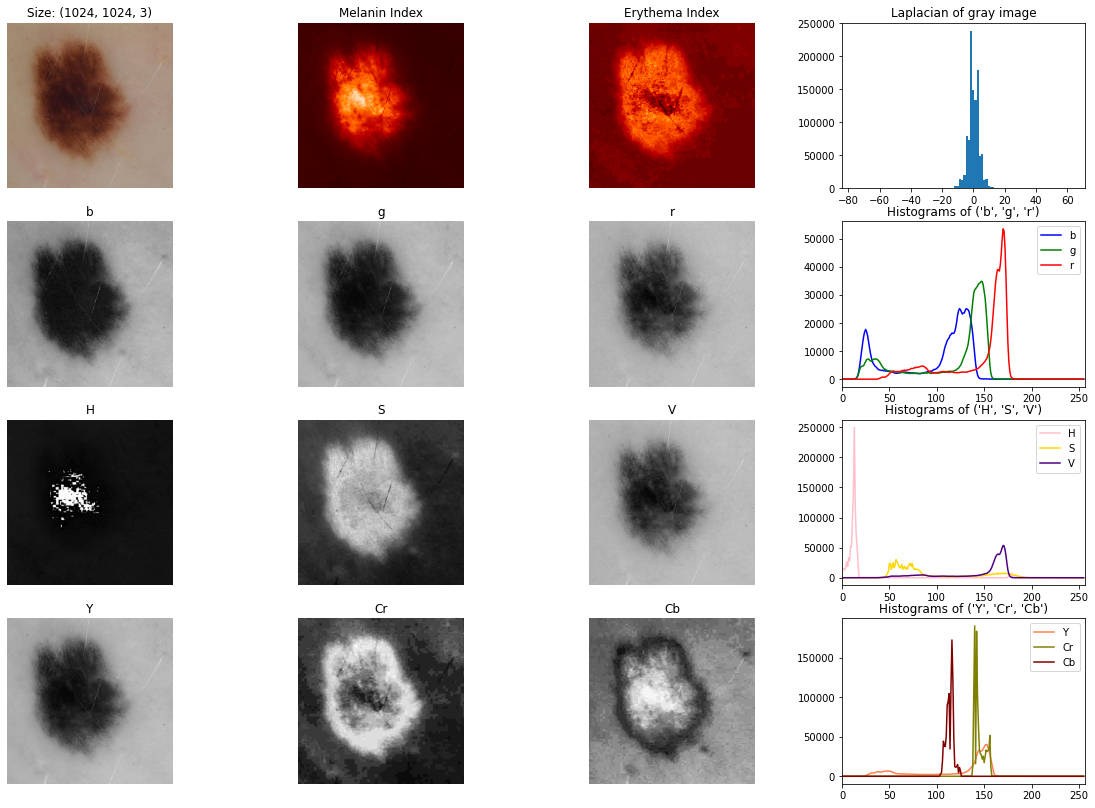

Percentiles of intensities in RGB space: {5: 26.0, 25: 95.0, 50: 133.0, 75: 152.0, 95: 171.0}
Percentiles of intensities in HSV space: {5: 66.0, 25: 135.0, 50: 163.0, 75: 169.0, 95: 173.0}
Percentiles of intensities in YCrCb space: {5: 38.0, 25: 98.0, 50: 143.0, 75: 151.0, 95: 157.0}
Sharpness Index: 
r: 14.33  g: 14.13  b: 14.56  H: 692.41  S: 21.43  V: 14.33  Y: 13.98  Cr: 0.60  Cb: 0.67  MI: 3.24  EI: 0.77  Gray: 13.98  
Full contrast: 0.73; clipped (1%-99%) contrast: 0.51
--------------------------------------------------------------------------------


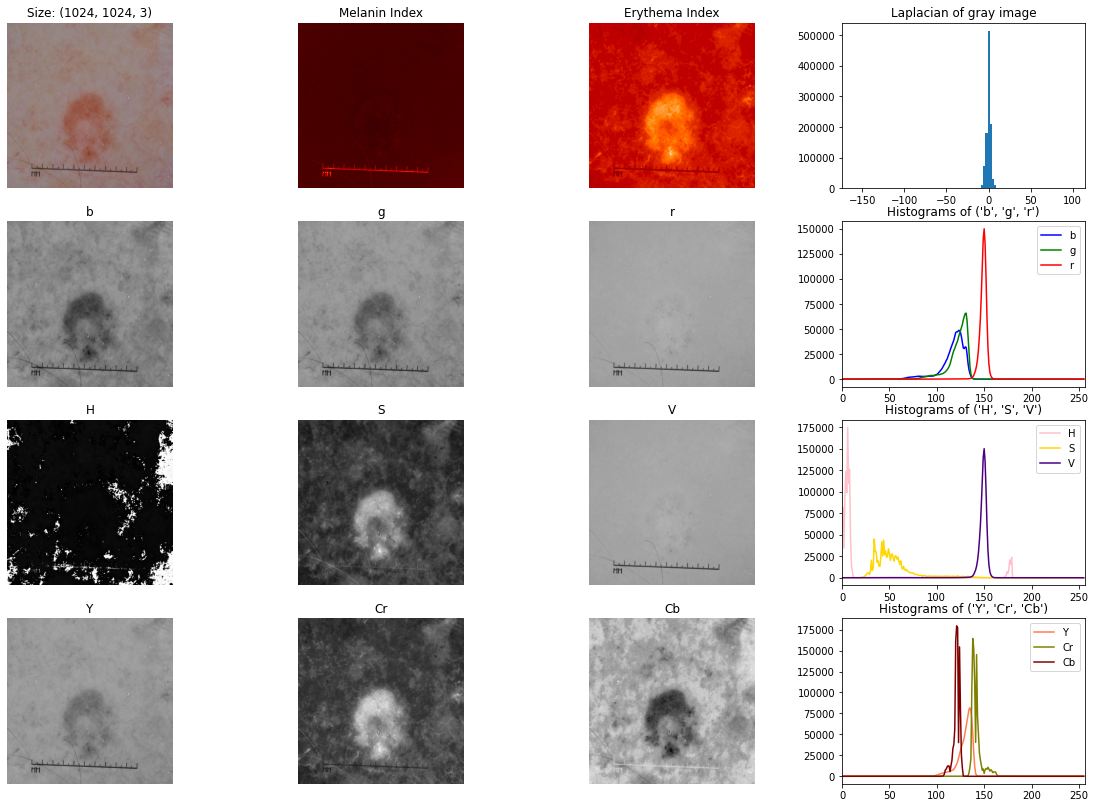

Percentiles of intensities in RGB space: {5: 99.0, 25: 119.0, 50: 128.0, 75: 147.0, 95: 152.0}
Percentiles of intensities in HSV space: {5: 143.0, 25: 147.0, 50: 149.0, 75: 151.0, 95: 154.0}
Percentiles of intensities in YCrCb space: {5: 111.0, 25: 126.0, 50: 132.0, 75: 135.0, 95: 138.0}
Sharpness Index: 
r: 15.11  g: 14.36  b: 15.03  H: 3379.82  S: 17.89  V: 15.11  Y: 13.95  Cr: 1.58  Cb: 1.28  MI: 3.69  EI: 0.67  Gray: 13.95  
Full contrast: 0.71; clipped (1%-99%) contrast: 0.16
--------------------------------------------------------------------------------


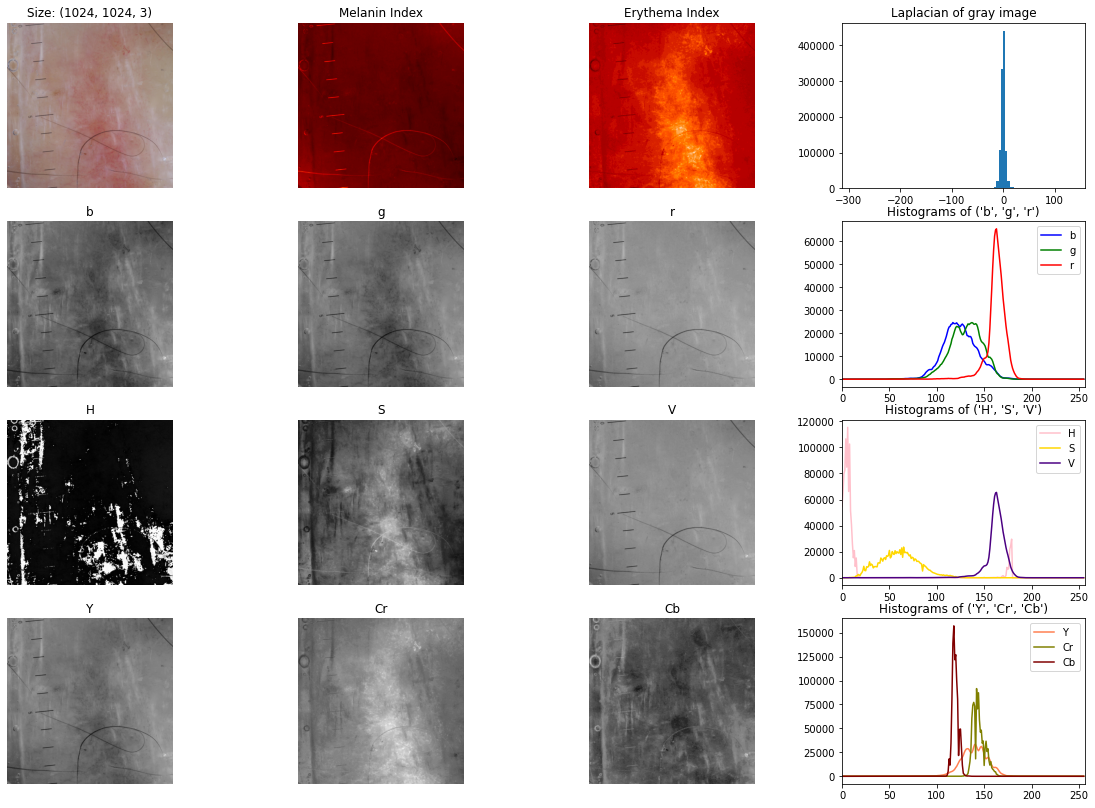

Percentiles of intensities in RGB space: {5: 103.0, 25: 122.0, 50: 139.0, 75: 160.0, 95: 171.0}
Percentiles of intensities in HSV space: {5: 147.0, 25: 159.0, 50: 163.0, 75: 168.0, 95: 176.0}
Percentiles of intensities in YCrCb space: {5: 118.0, 25: 131.0, 50: 140.0, 75: 149.0, 95: 162.0}
Sharpness Index: 
r: 32.95  g: 32.59  b: 33.43  H: 4862.11  S: 22.51  V: 33.05  Y: 31.69  Cr: 2.14  Cb: 1.85  MI: 5.20  EI: 0.89  Gray: 31.69  
Full contrast: 0.79; clipped (1%-99%) contrast: 0.27
--------------------------------------------------------------------------------


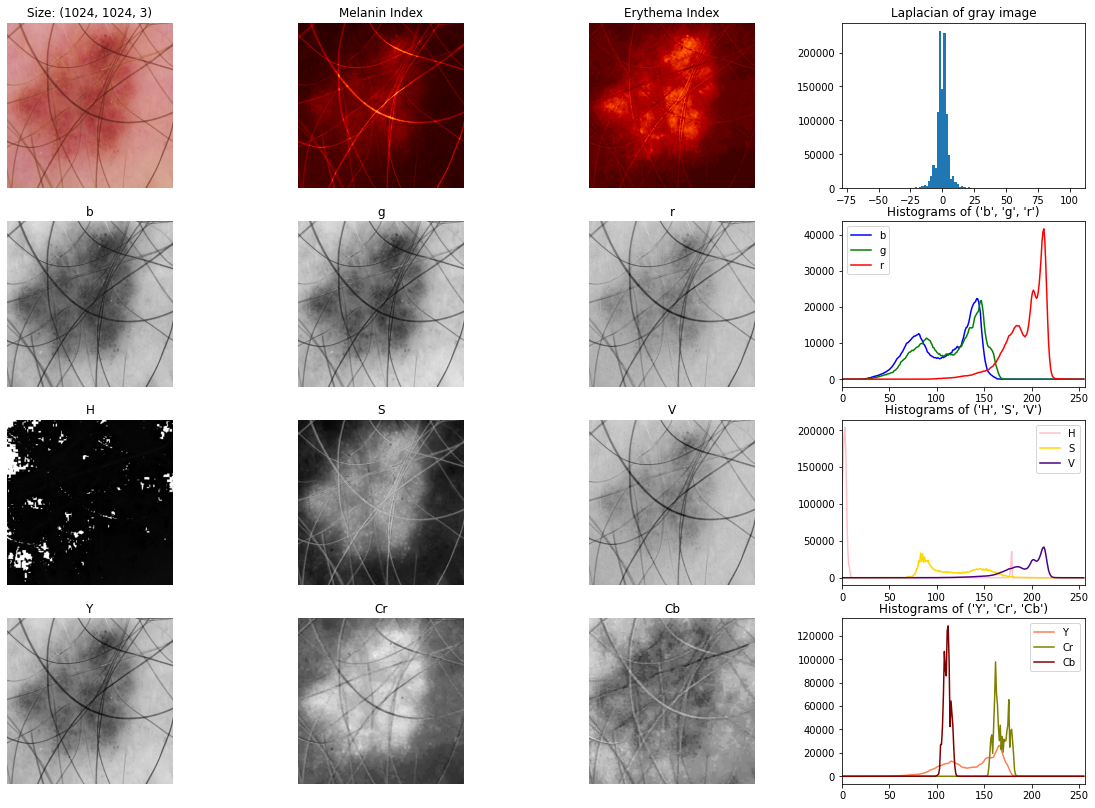

Percentiles of intensities in RGB space: {5: 64.0, 25: 98.0, 50: 139.0, 75: 181.0, 95: 213.0}
Percentiles of intensities in HSV space: {5: 153.0, 25: 181.0, 50: 200.0, 75: 210.0, 95: 216.0}
Percentiles of intensities in YCrCb space: {5: 91.0, 25: 115.0, 50: 145.0, 75: 163.0, 95: 172.0}
Sharpness Index: 
r: 25.13  g: 24.53  b: 25.22  H: 1719.37  S: 20.25  V: 25.13  Y: 24.30  Cr: 1.25  Cb: 1.22  MI: 3.17  EI: 0.86  Gray: 24.30  
Full contrast: 0.64; clipped (1%-99%) contrast: 0.42
--------------------------------------------------------------------------------


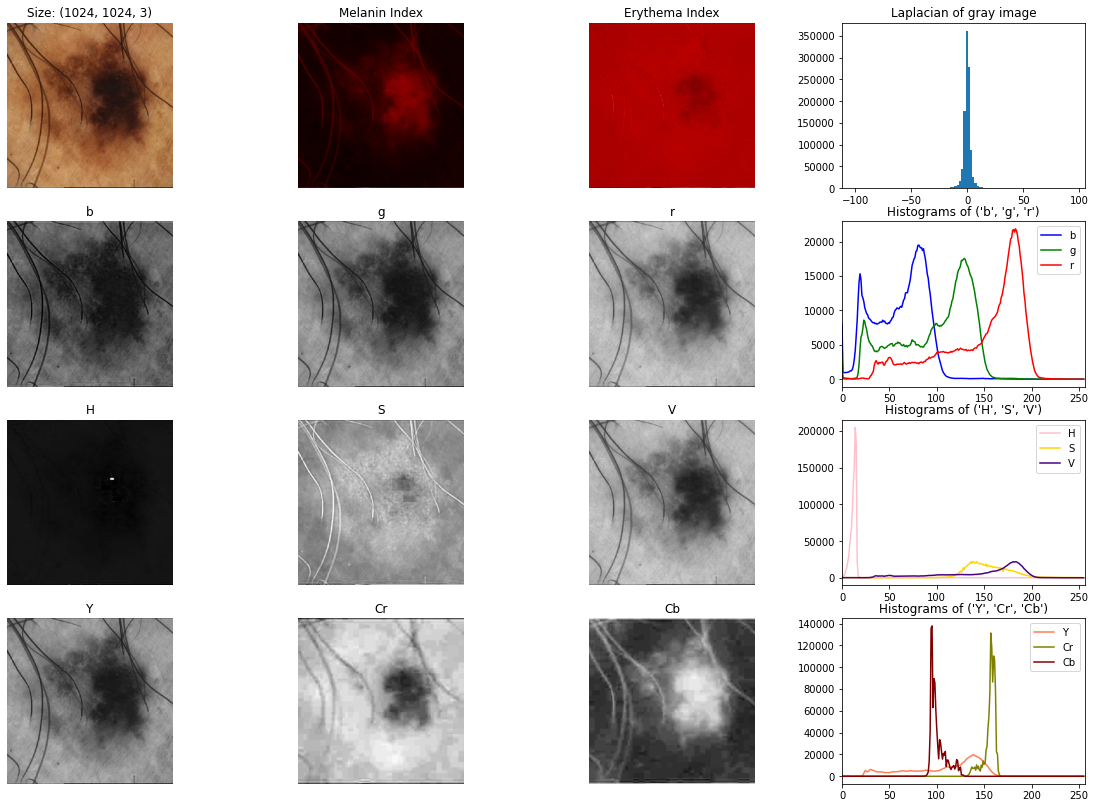

Percentiles of intensities in RGB space: {5: 22.0, 25: 62.0, 50: 96.0, 75: 141.0, 95: 187.0}
Percentiles of intensities in HSV space: {5: 52.0, 25: 122.0, 50: 166.0, 75: 182.0, 95: 194.0}
Percentiles of intensities in YCrCb space: {5: 32.0, 25: 80.0, 50: 122.0, 75: 139.0, 95: 153.0}
Sharpness Index: 
r: 38.11  g: 32.58  b: 28.79  H: 80.48  S: 228.96  V: 38.11  Y: 33.16  Cr: 2.08  Cb: 1.71  MI: 159.24  EI: 10.24  Gray: 33.15  
Full contrast: 0.93; clipped (1%-99%) contrast: 0.54
--------------------------------------------------------------------------------


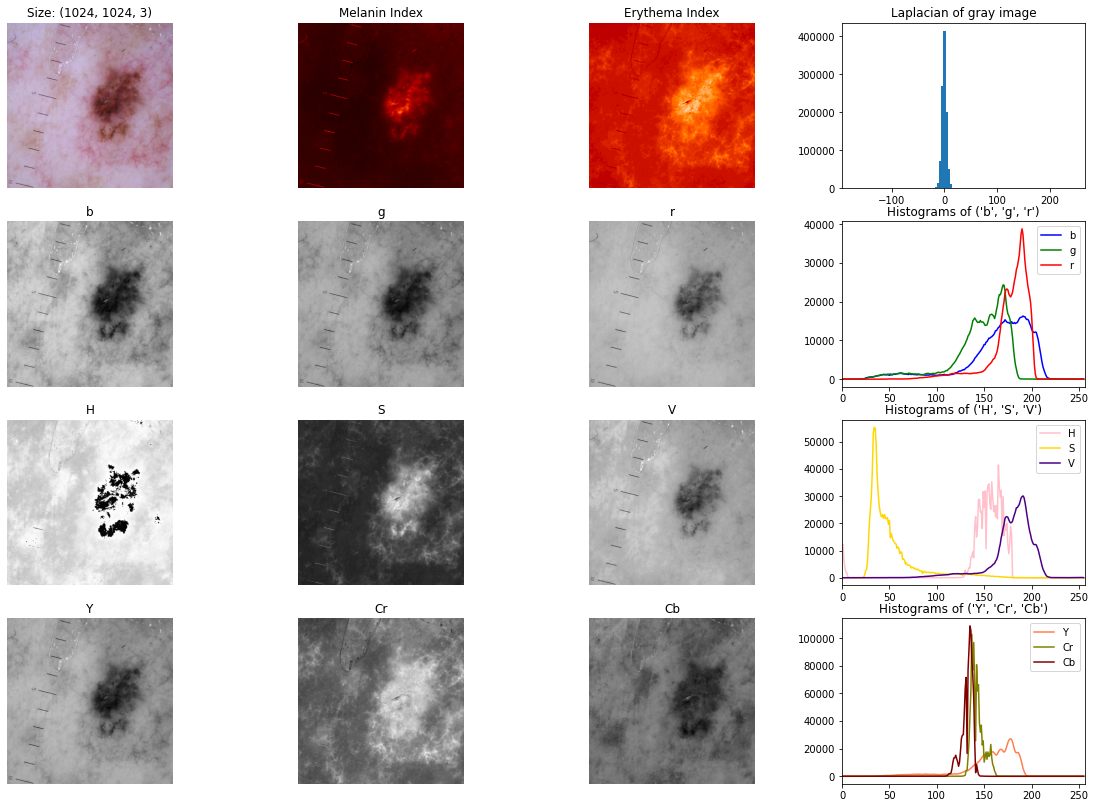

Percentiles of intensities in RGB space: {5: 90.0, 25: 149.0, 50: 171.0, 75: 186.0, 95: 200.0}
Percentiles of intensities in HSV space: {5: 130.0, 25: 172.0, 50: 184.0, 75: 193.0, 95: 206.0}
Percentiles of intensities in YCrCb space: {5: 89.0, 25: 148.0, 50: 164.0, 75: 177.0, 95: 187.0}
Sharpness Index: 
r: 47.22  g: 46.91  b: 50.26  H: 1179.09  S: 29.33  V: 48.60  Y: 45.88  Cr: 2.76  Cb: 2.44  MI: 7.88  EI: 1.05  Gray: 45.88  
Full contrast: 0.89; clipped (1%-99%) contrast: 0.53
--------------------------------------------------------------------------------


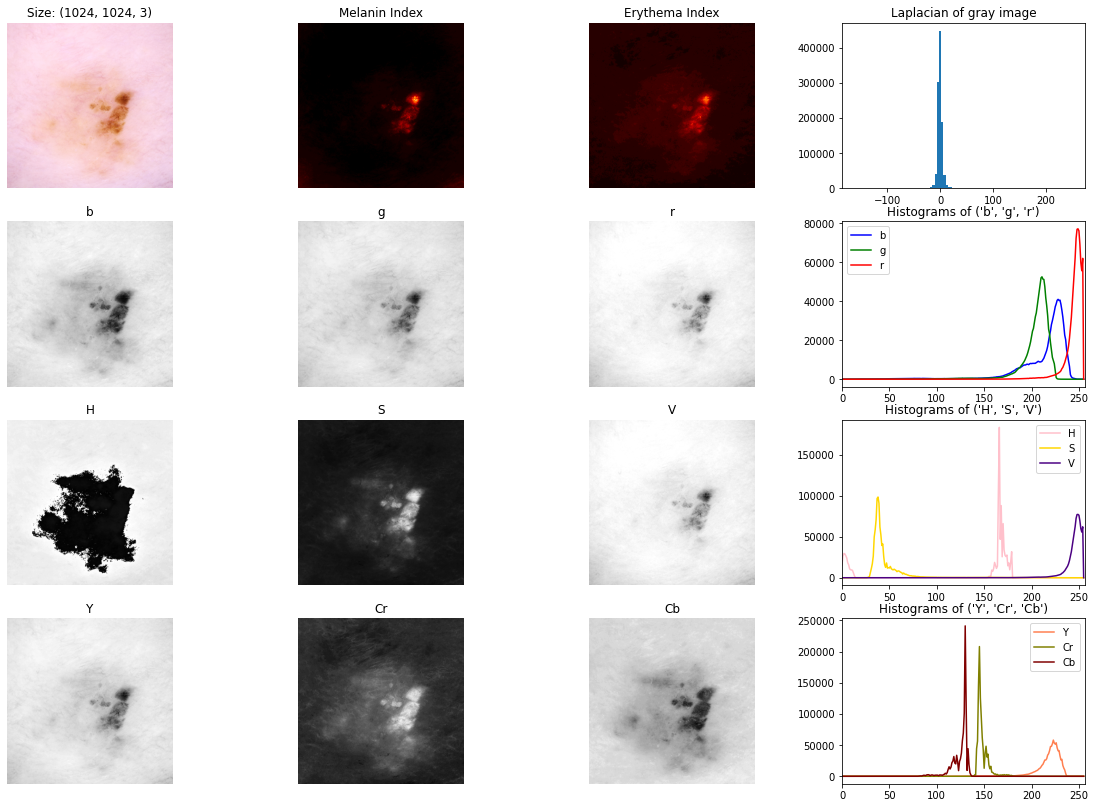

Percentiles of intensities in RGB space: {5: 181.0, 25: 208.0, 50: 223.0, 75: 244.0, 95: 253.0}
Percentiles of intensities in HSV space: {5: 231.0, 25: 244.0, 50: 248.0, 75: 251.0, 95: 255.0}
Percentiles of intensities in YCrCb space: {5: 194.0, 25: 215.0, 50: 222.0, 75: 226.0, 95: 232.0}
Sharpness Index: 
r: 22.29  g: 24.15  b: 28.21  H: 2404.44  S: 15.38  V: 22.30  Y: 22.38  Cr: 2.87  Cb: 2.74  MI: 1.70  EI: 0.63  Gray: 22.38  
Full contrast: 0.74; clipped (1%-99%) contrast: 0.38
--------------------------------------------------------------------------------


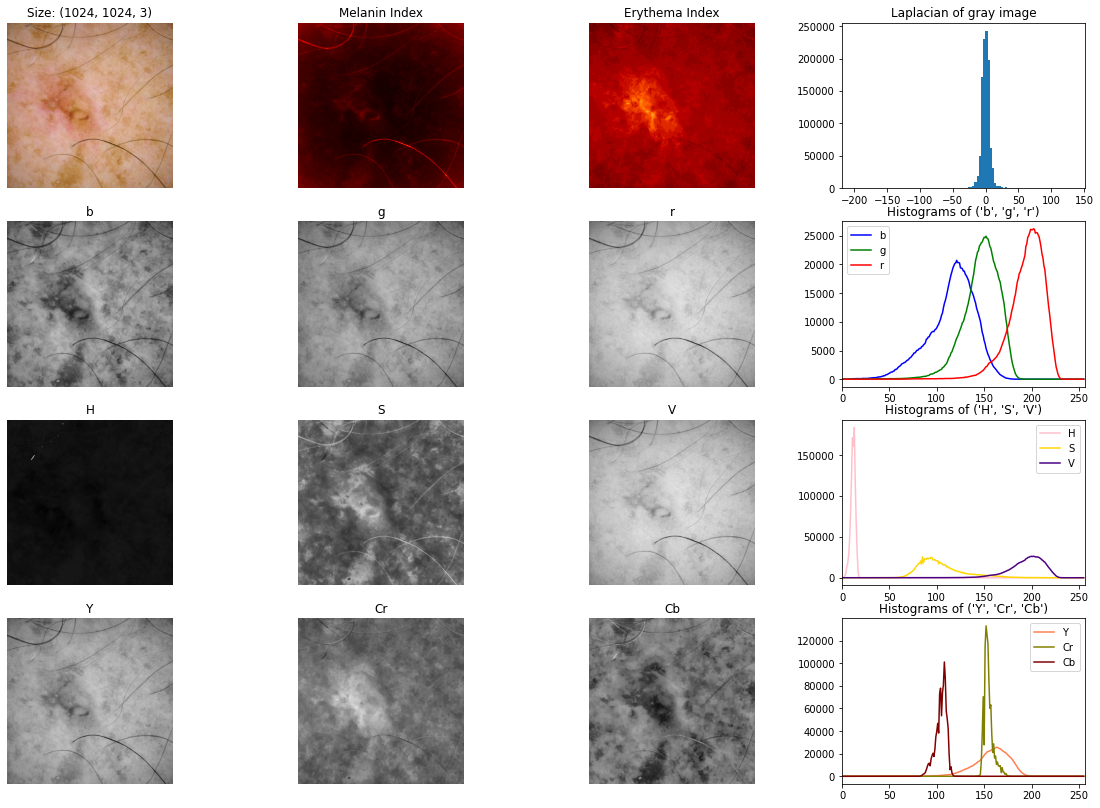

Percentiles of intensities in RGB space: {5: 88.0, 25: 126.0, 50: 150.0, 75: 185.0, 95: 212.0}
Percentiles of intensities in HSV space: {5: 161.0, 25: 185.0, 50: 198.0, 75: 208.0, 95: 219.0}
Percentiles of intensities in YCrCb space: {5: 125.0, 25: 148.0, 50: 160.0, 75: 171.0, 95: 183.0}
Sharpness Index: 
r: 54.81  g: 54.51  b: 57.73  H: 28.12  S: 50.18  V: 54.82  Y: 54.00  Cr: 1.55  Cb: 2.75  MI: 5.95  EI: 0.66  Gray: 54.00  
Full contrast: 0.85; clipped (1%-99%) contrast: 0.35
--------------------------------------------------------------------------------


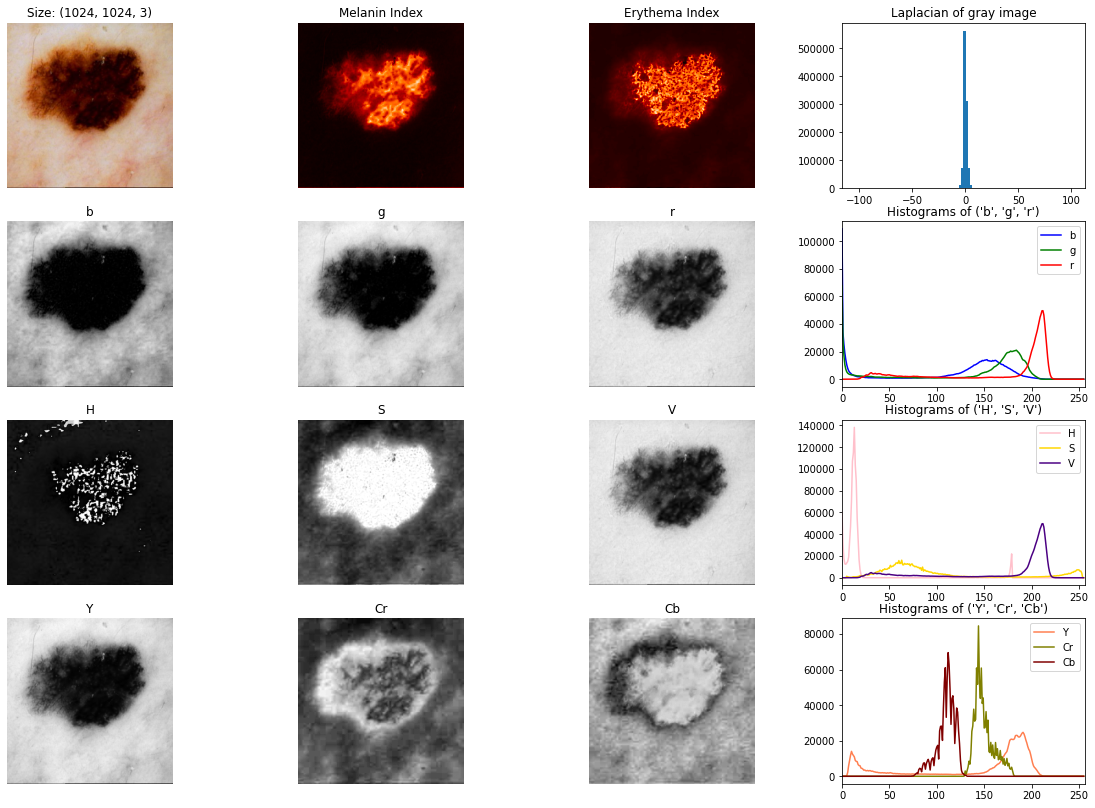

Percentiles of intensities in RGB space: {5: 0.0, 25: 89.0, 50: 164.0, 75: 194.0, 95: 213.0}
Percentiles of intensities in HSV space: {5: 36.0, 25: 157.0, 50: 204.0, 75: 211.0, 95: 216.0}
Percentiles of intensities in YCrCb space: {5: 11.0, 25: 94.0, 50: 176.0, 75: 188.0, 95: 199.0}
Sharpness Index: 
r: 10.69  g: 10.37  b: 9.64  H: 2290.74  S: 32.83  V: 10.69  Y: 10.46  Cr: 2.05  Cb: 2.40  MI: 4.20  EI: 20.32  Gray: 10.46  
Full contrast: 0.84; clipped (1%-99%) contrast: 0.77
--------------------------------------------------------------------------------


In [25]:
show_image_analytics(random9_mal, 'Malignant')
#show_image_analytics(random9_mal[:2], 'Malignant')

(0.0, 256.0)

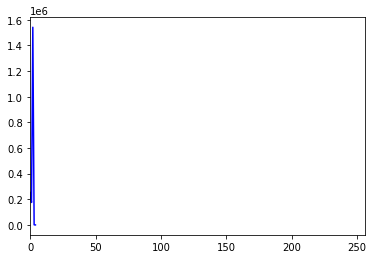

In [26]:
BGR_color = ('b','g','r')
img_BGR = read_imgBGR(random9_mal[0])
histr = cv2.calcHist([img_BGR],[0],None,[5],[0,255]) #excluding pure white 255 pixels of the borders in the images
plt.plot(histr,color = 'b', label = BGR_color[0])
plt.xlim([0,256])

I will explore here a new idea on control of color/hue balance for the human skin imagery based on:<br>
Face Detection by Color and Multilayer Feedforward Neural Network by **Chiunhsiun Lin** *(Proceedings of the 2005 IEEE International Conference on Information Acquisition - June 27 - July 3, 2005, Hong Kong and Macau, China*)<br>
They state that through experiment they derived that despite differences in skin color and lighting//exposure conditions leading to vastly different absolute values in RGB channels, they were able to use relative values to define skin regions within the images.<br>
Intensities of each channel in RGB space : (r (i), g (i), b (i)).<br>
Some constrains:<br>
**r (i) > α<br>
β1 < (r (i) – g (i)) < β2<br>
γ1 < (r (i) – b (i)) < γ2<br>**
Lets define the threshold constants:<br>
**alpha = 80;<br>
β1 = 16; β2 = 65;<br>
γ1 = 24; γ2 = 112<br>**
<br>
I'll implement these constrains and check if they are applicable to the close-up imagery of the skin with lesions.

In [27]:
img = img_BGR.copy()

In [28]:
a1 = 80; b1 = 16; b2 = 65; g1 = 24; g2 = 112
red = img[2]
blue = img[0]
green = img[1]
alpha = red.mean()
beta = (red.astype('int') - green.astype('int'))
gamma = (red.astype('int') - blue.astype('int'))
print(f'Mean values are: Alpha = {alpha:.2f}, Beta = {beta.mean():.2f}, Gamma = {gamma.mean():.2f}, Beta Min = {beta.min():.2f}, Gamma Min = {gamma.min():.2f}')

Mean values are: Alpha = 140.15, Beta = 0.09, Gamma = 0.19, Beta Min = -8.00, Gamma Min = -10.00


## Looking at the calculations we have to conclude that in our case this approach will not work as we have negative Gamma and Beta for too many cases, and it will not carry useful signal. It indicates wrong hue/color balance in the close-up images.

In [29]:
def check_skin_constrains(a, b, g):
    a1 = 80; b1 = 16; b2 = 65; g1 = 24; g2 = 112
    if (a <= a1):
        print('Not enough red')
    elif (b <= b1):
        print('Beta is too low') 
    elif (b >= b2):
        print('Beta is too high')
    elif (g > g1):
        print('Gamma is too low') 
    elif (g >= g2):
        print('Gamma is too high') 
    else:
        print('It is skin !')

In [30]:
check_skin_constrains(alpha, beta.mean(), gamma.mean())

Beta is too low


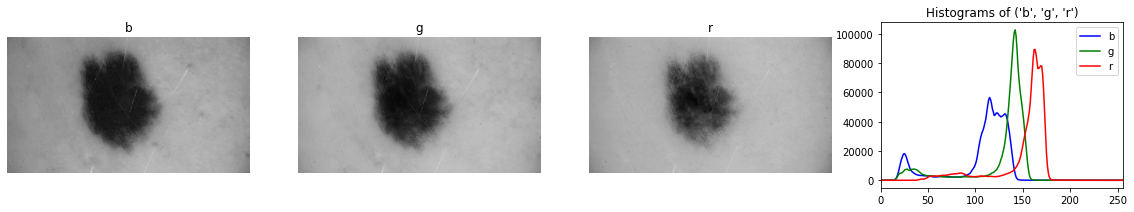

In [31]:
N_rows = 4
N_cols = 4
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(14)
for i,col in enumerate(BGR_color):
    ax = fig.add_subplot(N_rows, N_cols, N_cols + i + 1)
    imgplot = plt.imshow(img_BGR[:,:,i], cmap='gray')
    ax.set_title(col)
    plt.axis('off')

ax = fig.add_subplot(N_rows, N_cols, N_cols * 1 + 4)
ax.set_title(f'Histograms of {BGR_color}')
for i,col in enumerate(BGR_color):
    histr = cv2.calcHist([img_BGR],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
    plt.plot(histr,color = col, label = BGR_color[i])
    plt.xlim([0,256])
ax.legend()

In [32]:
img_hsv = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2HSV)
img_ycb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCR_CB)

In [33]:
h = img_hsv[:,:,0]
s = img_hsv[:,:,1]
v = img_hsv[:,:,2]
print(h.min() , h.max())
print(s.min() , s.max())
print(v.min() , v.max())


0 179
32 222
35 222


In [34]:
y = img_ycb[:,:,0]
cr = img_ycb[:,:,1]
cb = img_ycb[:,:,2]
print(y.min() , y.max())
print(cr.min() , cr.max())
print(cb.min() , cb.max())

19 207
133 159
102 126


In [35]:
print((beta +13).min(), beta.max())
print((red.astype('float') - blue.astype('float')).min())
print((red.astype('float') - blue.astype('float')).max())

5 7
-10.0
14.0
